In [53]:
%pylab inline

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.init as init
from torch.autograd import Variable

import numpy as np
from random import randint, seed

# Flag to enable execution on GPU
# device = torch.device('cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cuda = torch.cuda.is_available()

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['randint', 'seed']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [70]:
device

device(type='cuda')

In [0]:
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

# Loading the MNIST dataset
train_set = MNIST('./data/MNIST', download=True, train=True, transform=ToTensor())
test_set = MNIST('./data/MNIST', download=True, train=False, transform=ToTensor())

In [0]:
from torch.utils.data import DataLoader

n_train_samples = len(train_set) # number of train samples
n_test_samples = len(test_set) # number of test samples

np.random.seed(1234)
torch.manual_seed(1234)

# generate samples
seed(1234)

batch_size = 64

# Initialization of the data loader
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=1)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=1)

In [0]:
from torch.nn.functional import softplus, softmax

class MLP(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_classes, neg_slope=0.02):
        super(MLP, self).__init__()
        self.n_inputs = n_inputs,
        self.n_hidden = n_hidden,
        self.n_classes = n_classes
        
        self.layers = []
        self.num_neurons = [n_inputs] + n_hidden + [n_classes]
        self.models = {}
        for i in range(len(self.num_neurons) - 2):
            self.layers.append(nn.Linear(self.num_neurons[i], self.num_neurons[i+1]))
            self.layers.append(nn.LeakyReLU(negative_slope=neg_slope))
            self.models['Linear{}'.format(i)] = nn.Sequential(*self.layers)
            

        self.layers.append(nn.Linear(self.num_neurons[i+1], self.num_neurons[i+2]))
        self.models['Output'] = nn.Sequential(*self.layers)
        self.full_model = self.models['Output']
        
        
        
    def forward(self, x, exitLayer=None): 
        if exitLayer is not None:
            out = self.models[exitLayer](x)
        else:
            out = self.full_model(x)
        return out
'''
class VAE(nn.Module):
    def __init__(self, z_dim):
        super(VAE, self).__init__()
        
        self.z_dim = z_dim
        
        # Vanilla MLP
        self.net = nn.Sequential(
            nn.Linear(10, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 1024),
            nn.ReLU(True),
            nn.Linear(1024, z_dim*2),
        )
        
    def forward(self, x):
        x = x.view(x.size(0),-1) # Flatten the input
        params = self.net(x)
        
        mu, sigma = params[:,:self.z_dim], params[:,self.z_dim:]
        sigma = softplus(sigma) + 1e-7  # Make sigma always positive
        
        return Independent(Normal(loc=mu, scale=sigma), 1) # Return a factorized Normal distribution
'''


class VAE(nn.Module):

    def __init__(self, x_dim, y_dim, z_dim=6):
        super(VAE, self).__init__()
        self.K = z_dim

        self.encode = nn.Sequential(
            nn.Linear(x_dim, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 2*self.K))

        self.decode = nn.Sequential(
                nn.Linear(self.K, y_dim))

    def forward(self, x, num_sample=1):
        if x.dim() > 2 : x = x.view(x.size(0),-1)

        statistics = self.encode(x)
        mu = statistics[:,:self.K]
        std = softplus(statistics[:,self.K:]-5,beta=1)

        encoding = self.reparametrize_n(mu, std, num_sample)
        logit = self.decode(encoding)

        if num_sample == 1 : pass
        elif num_sample > 1 : logit = softmax(logit, dim=2).mean(0)

        return (mu, std), logit, encoding

    def reparametrize_n(self, mu, std, n=1):
        # reference :
        # http://pytorch.org/docs/0.3.1/_modules/torch/distributions.html#Distribution.sample_n
        def expand(v):
            if isinstance(v, Number):
                return torch.Tensor([v]).expand(n, 1)
            else:
                return v.expand(n, *v.size())

        if n != 1 :
            mu = expand(mu)
            std = expand(std)

        eps = Variable(std.data.new(std.size()).normal_().to(device))

        return mu + eps * std

    def weight_init(self):
        for m in self._modules:
            xavier_init(self._modules[m])


def xavier_init(ms):
    for m in ms :
        if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform(m.weight,gain=nn.init.calculate_gain('relu'))
            m.bias.data.zero_()

In [0]:
def get_named_layers(net):
    conv2d_idx = 0
    convT2d_idx = 0
    linear_idx = 0
    batchnorm2d_idx = 0
    named_layers = {}
    for mod in net.modules():
        if isinstance(mod, torch.nn.Conv2d):
            layer_name = 'Conv2d{}_{}-{}'.format(
                conv2d_idx, mod.in_channels, mod.out_channels
            )
            named_layers[layer_name] = mod
            conv2d_idx += 1
        elif isinstance(mod, torch.nn.ConvTranspose2d):
            layer_name = 'ConvT2d{}_{}-{}'.format(
                conv2d_idx, mod.in_channels, mod.out_channels
            )
            named_layers[layer_name] = mod
            convT2d_idx += 1
        elif isinstance(mod, torch.nn.BatchNorm2d):
            layer_name = 'BatchNorm2D{}_{}'.format(
                batchnorm2d_idx, mod.num_features)
            named_layers[layer_name] = mod
            batchnorm2d_idx += 1
        elif isinstance(mod, torch.nn.Linear):
            layer_name = 'Linear{}_{}-{}'.format(
                linear_idx, mod.in_features, mod.out_features
            )
            named_layers[layer_name] = mod
            linear_idx += 1
    return named_layers

def accuracy(predictions, targets, mnist=True):
    if mnist:
        accuracy = (predictions.argmax(dim=1) == targets).type(torch.FloatTensor).mean().item()
    else:
        accuracy = (predictions.argmax(dim=1) == targets.argmax(dim=1)).type(torch.FloatTensor).mean().item()
    return accuracy

In [59]:
# Single time define the testing set. Keep it fixed until the end
xs = []
ys = []

for x, y in test_loader:
    xs.append(x)
    ys.append(y)

xs = torch.cat(xs, 0)
ys = torch.cat(ys, 0)

X_test, y_test = torch.tensor(xs, requires_grad=False).flatten(start_dim=1).to(device), torch.tensor(ys, requires_grad=False).type(torch.LongTensor).to(device)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


In [8]:
dnn_hidden_units = [1024, 512, 256, 128, 64]
dnn_input_units = X_test.shape[-1]
dnn_output_units = 10 #y.shape[-1] if y.ndim > 1 else 1

# MLP_object = VAE(dnn_input_units, dnn_output_units).to(device)
MLP_object = MLP(dnn_input_units, dnn_hidden_units, dnn_output_units)
get_named_layers(MLP_object)
#MLP_object.parameters()
#print(MLP_object.models)

{'Linear0_784-1024': Linear(in_features=784, out_features=1024, bias=True),
 'Linear1_1024-512': Linear(in_features=1024, out_features=512, bias=True),
 'Linear2_512-256': Linear(in_features=512, out_features=256, bias=True),
 'Linear3_256-128': Linear(in_features=256, out_features=128, bias=True),
 'Linear4_128-64': Linear(in_features=128, out_features=64, bias=True),
 'Linear5_64-10': Linear(in_features=64, out_features=10, bias=True)}

In [0]:
from collections import Counter

#Calculate real MI throughout training
def calc_mutual_information(hidden):
    n_neurons = hidden.shape[-1]
  
    # discretization 
    n_bins = 30
    bins = np.linspace(-1, 1, n_bins+1)
    indices = np.digitize(hidden, bins)
    
    # initialize pdfs
    pdf_x = Counter(); pdf_y = Counter(); pdf_t = Counter(); pdf_xt = Counter(); pdf_yt = Counter()

    for i in range(n_train_samples):
        pdf_x[x_train_int[i]] += 1/float(n_train_samples)
        pdf_y[y_train[i,0]] += 1/float(n_train_samples)      
        pdf_xt[(x_train_int[i],)+tuple(indices[i,:])] += 1/float(n_train_samples)
        pdf_yt[(y_train[i,0],)+tuple(indices[i,:])] += 1/float(n_train_samples)
        pdf_t[tuple(indices[i,:])] += 1/float(n_train_samples)
    
    # calcuate encoder mutual information I(X;T)
    mi_xt = 0
    for i in pdf_xt:
        # P(x,t), P(x) and P(t)
        p_xt = pdf_xt[i]; p_x = pdf_x[i[0]]; p_t = pdf_t[i[1:]]
        # I(X;T)
        mi_xt += p_xt * np.log(p_xt / p_x / p_t)
 
    # calculate decoder mutual information I(T;Y)
    mi_ty = 0
    for i in pdf_yt:
        # P(t,y), P(t) and P(y)
        p_yt = pdf_yt[i]; p_t = pdf_t[i[1:]]; p_y = pdf_y[i[0]]
        # I(T;Y)
        try:
          mi_ty += p_yt * np.log(p_yt / p_t / p_y)
        except ZeroDivisionError:
          mi_ty += p_yt * np.log(p_yt / (p_t + 1e-5) / (p_y + 1e-5))
            
    return mi_xt, mi_ty

# get mutual information for all hidden layers
def get_mutual_information(hidden):
    mi_xt_list = []; mi_ty_list = []
    # for hidden in hiddens:
    if True:
        mi_xt, mi_ty = calc_mutual_information(hidden)
        mi_xt_list.append(mi_xt)
        mi_ty_list.append(mi_ty)
    return mi_xt_list, mi_ty_list

In [63]:
from tqdm import tqdm


def train_encoder(z_dim = 6, enc_type='MLP', layer='Linear3', weight_decay=0, num_epochs=10, eval_freq=1, beta=1):
  
    if enc_type == 'MLP':
        Net = MLP(dnn_input_units, dnn_hidden_units, dnn_output_units).to(device)
    elif enc_type =='VAE':
        Net = VAE(dnn_input_units, dnn_output_units, z_dim).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(Net.parameters(), lr=3e-3, weight_decay=weight_decay)#, momentum=0.2)

    # X_test, Y_test = torch.tensor(x_test, requires_grad=False).float().to(device), torch.tensor(y_test, requires_grad=False).float().to(device)
    accuracy_evaluation = {'train': [], 'test': []}
    loss_evaluation = {'train': [], 'test': []}
    mi_xt_all = []; mi_ty_all = []; epochs = []
    start_time = time.time()
    max_accuracy = 0

    for epoch in range(num_epochs):
        for X_train, y_train in train_loader:

            X_train, y_train = X_train.flatten(start_dim=1).to(device), y_train.to(device)
        
            optimizer.zero_grad()
            if enc_type =='VAE':
                (mu, std), out, z_train = Net(X_train)
                class_loss = criterion(out, y_train).div(math.log(2))
                info_loss = -0.5 * (1 + 2 * std.log() - mu.pow(2) - std.pow(2)).sum(1).mean().div(math.log(2))
                loss = class_loss + beta * info_loss
            else:
                out = Net(X_train)
                loss = criterion(out, y_train)
            loss.backward()
            optimizer.step()

        if epoch % eval_freq == 0 or epoch == num_epochs - 1:

                # if enc_type =='MLP':
                #     mi_xt, mi_ty = get_mutual_information(Net.models[layer](X_train).cpu().data.numpy())
                # else:
                #     mi_xt, mi_ty = get_mutual_information(z_train.cpu().data.numpy())
                # mi_xt_all.append(mi_xt)
                # mi_ty_all.append(mi_ty)

                print('\n'+'#'*30)
                print('Training epoch - %d/%d' % (epoch+1, num_epochs))

                if enc_type == 'VAE':
                    (mu, std), out_test, z_test = Net(X_test)
                    test_class_loss = criterion(out, y_train).div(math.log(2))
                    test_info_loss = -0.5 * (1 + 2 * std.log() - mu.pow(2) - std.pow(2)).sum(1).mean().div(math.log(2))
                    test_loss = test_class_loss + beta * test_info_loss
                else:
                    out_test = Net(X_test)
                    test_loss = criterion(out_test, y_test)
                test_accuracy = accuracy(out_test, y_test)
                if test_accuracy > max_accuracy:
                    max_accuracy = test_accuracy

                print('Train: Accuracy - %0.3f, Loss - %0.3f' % (accuracy(out, y_train), loss))
                print('Test: Accuracy - %0.3f, Loss - %0.3f' % (test_accuracy, test_loss))
                # print('I(X, %s) - %s' % (layer, mi_xt))
                # print('I(%s, Y) - %s' % (layer, mi_ty))
                print('Elapse time: ', time.time() - start_time)
                print('#'*30,'\n')
                if test_accuracy == 1 and test_loss == 0:
                    break

    return Net, max_accuracy

enc_type = 'VAE'
Encoder, performance = train_encoder(enc_type=enc_type, beta=1)#, weight_decay=0.01)
print('Best achieved performance: ', performance)
print(Encoder)



 57%|█████▋    | 533/938 [00:21<00:06, 63.50it/s]


##############################
Training epoch - 1/10
Train: Accuracy - 0.938, Loss - 0.430
Test: Accuracy - 0.962, Loss - 0.438
Elapse time:  13.203227996826172
############################## 


##############################
Training epoch - 2/10
Train: Accuracy - 0.969, Loss - 0.281
Test: Accuracy - 0.968, Loss - 0.275
Elapse time:  26.172807931900024
############################## 


##############################
Training epoch - 3/10
Train: Accuracy - 0.938, Loss - 0.455
Test: Accuracy - 0.969, Loss - 0.458
Elapse time:  39.14405846595764
############################## 


##############################
Training epoch - 4/10
Train: Accuracy - 1.000, Loss - 0.127
Test: Accuracy - 0.973, Loss - 0.135
Elapse time:  52.232301235198975
############################## 


##############################
Training epoch - 5/10
Train: Accuracy - 1.000, Loss - 0.162
Test: Accuracy - 0.975, Loss - 0.163
Elapse time:  65.23678660392761
############################## 


##########################

In [0]:
# Neural approximation of MI starts here
# Auxiliary network for mutual information estimation
class MIEstimator(nn.Module):
    def __init__(self, size1, size2):
        super(MIEstimator, self).__init__()
        
        # Vanilla MLP
        self.net = nn.Sequential(
            nn.Linear(size1 + size2, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 1),
        )
    
    # Gradient for JSD mutual information estimation and EB-based estimation
    def forward(self, x1, x2):
        # breakpoint()
        pos = self.net(torch.cat([x1, x2], 1)) #Positive Samples 
        neg = self.net(torch.cat([torch.roll(x1, 1, 0), x2], 1)) #Predictions for shuffled (negative) samples from p(z1)p(z2)
        #breakpoint()
        return -softplus(-pos).mean() - softplus(neg).mean(), pos.mean() - neg.exp().mean() + 1

In [0]:
from torch.utils.data import Subset
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

class Scheduler:
    def __call__(self, **kwargs):
        raise NotImplemented()

class LinearScheduler(Scheduler):
    def __init__(self, start_value, end_value, n_iterations, start_iteration=0):
        self.start_value = start_value
        self.end_value = end_value
        self.n_iterations = n_iterations
        self.start_iteration = start_iteration
        self.m = (end_value - start_value) / n_iterations

    def __call__(self, iteration):
        if iteration > self.start_iteration + self.n_iterations:
            return self.end_value
        elif iteration <= self.start_iteration:
            return self.start_value
        else:
            return (iteration - self.start_iteration) * self.m + self.start_value

class ExponentialScheduler(LinearScheduler):
    def __init__(self, start_value, end_value, n_iterations, start_iteration=0, base=10):
        self.base = base

        super(ExponentialScheduler, self).__init__(start_value=math.log(start_value, base),
                                                   end_value=math.log(end_value, base),
                                                   n_iterations=n_iterations,
                                                   start_iteration=start_iteration)

    def __call__(self, iteration):
        linear_value = super(ExponentialScheduler, self).__call__(iteration)
        return self.base ** linear_value

def split(dataset, size, split_type):
    if split_type == 'Random':
        data_split, _ = torch.utils.data.random_split(dataset, [size, len(dataset) - size])
    elif split_type == 'Balanced':
        class_ids = {}
        for idx, (_, y) in enumerate(dataset):
            if y not in class_ids:
                class_ids[y] = []
            class_ids[y].append(idx)

        ids_per_class = size // len(class_ids)

        selected_ids = []

        for ids in class_ids.values():
            selected_ids += list(np.random.choice(ids, min(ids_per_class, len(ids)), replace=False))
        data_split = torch.utils.data.Subset(dataset, selected_ids)

    return data_split


class EmbeddedDataset:
    BLOCK_SIZE = 256

    def __init__(self, base_dataset, encoder, enc_type, cuda=True):
        if cuda:
            encoder = encoder.cuda()
        self.means, self.target = self._embed(encoder, base_dataset, cuda)

    def _embed(self, encoder, dataset, cuda):
        encoder.eval()

        data_loader = torch.utils.data.DataLoader(
            dataset,
            batch_size=self.BLOCK_SIZE,
            shuffle=False)

        ys = []
        reps = []
        with torch.no_grad():
            for x, y in data_loader:
                x = x.flatten(start_dim=1)
                if cuda:
                    x = x.cuda()
                    y = y.cuda()
                if enc_type == 'VAE':
                    (_, _), _, p_z_given_x = encoder(x)
                else: 
                    p_z_given_x = encoder(x)
                reps.append(p_z_given_x.detach())
                ys.append(y)
            ys = torch.cat(ys, 0)

        encoder.train()
        return reps, ys

    def __getitem__(self, index):
        y = self.target[index]
        # x = self.means[index][0]
        x = self.means[index // self.BLOCK_SIZE][index % self.BLOCK_SIZE]
        return x, y

    def __len__(self):
        return self.target.size(0)

def train_and_evaluate_linear_model(train_set, test_set, solver='saga', multi_class='multinomial', tol=.1, C=2):
    model = LogisticRegression(solver=solver, multi_class=multi_class, tol=tol, C=C)
    scaler = MinMaxScaler()

    x_train, y_train = build_matrix(train_set)
    x_test, y_test = build_matrix(test_set)
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    model.fit(x_train, y_train)
    test_accuracy = model.score(x_test, y_test)
    train_accuracy = model.score(x_train, y_train)

    return train_accuracy, test_accuracy


def build_matrix(dataset):
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=256, shuffle=False)

    xs = []
    ys = []

    for x, y in data_loader:
        xs.append(x)
        ys.append(y)

    xs = torch.cat(xs, 0)
    ys = torch.cat(ys, 0)

    if xs.is_cuda:
        xs = xs.cpu()
    if ys.is_cuda:
        ys = ys.cpu()

    return xs.data.numpy(), ys.data.numpy()

def evaluate(encoder, enc_type, train_on, test_on, cuda):
    embedded_train = EmbeddedDataset(train_on, encoder, enc_type, cuda=cuda)
    embedded_test = EmbeddedDataset(test_on, encoder, enc_type, cuda=cuda)
    return train_and_evaluate_linear_model(embedded_train, embedded_test)

def onehot_encoding(x, num_classes=10):
    x_onehot = torch.FloatTensor(x.shape[0], num_classes)
    x_onehot.zero_()
    x_onehot.scatter_(1, x.view(x.shape[0], 1), 1)
    return x_onehot

In [73]:
import pandas as pd

def train_MI(encoder, beta=None, num_epochs=2000, estimate_mi_on_train=True):
    
    if estimate_mi_on_train:
        loader = train_loader
    else:
        loader = test_loader

    if enc_type == 'VAE':
       (_, _), _, z_test = encoder(X_test)
    else:
       z_test = encoder(X_test)
    z_test = torch.tensor(z_test, requires_grad=False).to(device)

    x_dim, y_dim, z_dim = X_test.shape[-1], dnn_output_units, z_test.shape[-1]
    print(x_dim, y_dim, z_dim)
    mi_estimator_X = MIEstimator(x_dim, z_dim).to(device)
    mi_estimator_Y = MIEstimator(z_dim, y_dim).to(device)

    optimizer = optim.Adam([
    {'params': mi_estimator_X.parameters(), 'lr':1e-4},
    {'params': mi_estimator_Y.parameters(), 'lr':1e-4},
    ])
    if beta is None:
        use_scheduler = True
        beta_scheduler = ExponentialScheduler(start_value=1e-9, end_value=1e-1, n_iterations=500, start_iteration=1)
    else:
        use_scheduler = False

    start_time = time.time()
    max_MI_x, max_MI_y = 0, 0
    mi_mean_est_all = {'X': [], 'Y': []}
    
    for epoch in range(num_epochs):
        if use_scheduler:
            beta = beta_scheduler(epoch)
        mi_over_epoch = {'X': [], 'Y': []}
        for X, y in loader:
            y = onehot_encoding(y)
            X, y = X.flatten(start_dim=1).to(device), y.float().to(device)

            if enc_type == 'VAE':
                (_, _), _, z = encoder(X)
            else:
                z = encoder(X)
            optimizer.zero_grad()
            mi_gradient_X, mi_estimation_X = mi_estimator_X(X, z)
            mi_gradient_X = mi_gradient_X.mean()
            mi_estimation_X = mi_estimation_X.mean()

            mi_gradient_Y, mi_estimation_Y = mi_estimator_Y(z, y)
            mi_gradient_Y = mi_gradient_Y.mean()
            mi_estimation_Y = mi_estimation_Y.mean()
                    
            loss_mi = - mi_gradient_Y - beta * mi_gradient_X
            loss_mi.backward()
            optimizer.step()
            mi_over_epoch['X'].append(mi_estimation_X.item())
            mi_over_epoch['Y'].append(mi_estimation_Y.item())
            if mi_estimation_X.item() > max_MI_x and epoch > 5:#10:
                max_MI_x = mi_estimation_X.item()
                max_MI_y = mi_estimation_Y.item()
        mi_mean_est_all['X'].append(np.mean(mi_over_epoch['X']))
        mi_mean_est_all['Y'].append(np.mean(mi_over_epoch['Y']))
        eval_freq = 1
            
        # if epoch >= 50 and np.mean(mi_est_all['X'][-50]) > max_MI_x - 1e-1:
        #     break
        if epoch % eval_freq == 0 or epoch == num_epochs - 1:
            #if mi_estimation_X.item() > max_MI_x and epoch > 5:
            #    max_MI_x = mi_estimation_X.item()
            #    max_MI_y = mi_estimation_Y.item()
            
            # if epoch >= 15 and np.mean(mi_est_all['X'][-10]) > max_MI_x - 1e-1:
            #     break

            print('#'*30)
            print('Step - ', epoch)
            print('Beta - ', beta)
                
            # print('Mean MI X', np.mean(mi_mean_est_all['X']))
            # print('Mean MI Y', np.mean(mi_mean_est_all['Y']))
            if epoch >= 1:

              delta_x = np.abs(mi_mean_est_all['X'][-2] - mi_mean_est_all['X'][-1])
              print('Delta X: ', delta_x)
              
              delta_y = np.abs(mi_mean_est_all['Y'][-2] - mi_mean_est_all['Y'][-1])
              print('Delta Y: ', delta_y)
              print('\nMean MI X for last 10', mi_mean_est_all['X'][-10:])
              print('Mean MI Y for last 10', mi_mean_est_all['Y'][-10:])
              mi_df = pd.DataFrame.from_dict(mi_mean_est_all)
              mi_df.to_csv('mi_mlp.csv', sep=' ')
            # print('I_est(X, %s) - %s' % (layer, mi_estimation_X.item()))
            #print('Grad I_est(X, T)', mi_gradient_X)
            # print('I_est(%s, Y) - %s' % (layer, mi_estimation_Y.item()))
            # print('Max I_est(X, %s) - %s' % (layer, max_MI_x))
            #print('Grad I_est(X, T)', mi_gradient_X)
            # print('Max I_est(%s, Y) - %s' % (layer, max_MI_y))
            #print('Grad I_est(T, Y)', mi_gradient_Y)
            print('Elapsed time training MI for %s: %s' % (layer, time.time() - start_time))
            print('#'*30,'\n')

            
    return max_MI_x, max_MI_y


batch_size = 64

# Initialization of the data loader
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=1)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=1)

num_classes = 10
labels_per_class = [2**i for i in range(0, int(np.log2(n_train_samples/num_classes)))]
num_labels_range = num_classes * np.array(labels_per_class)
# layers = ['Linear2', 'Linear3', 'Linear4']
layers = ['Linear4']
if enc_type == 'MLP':   
    acc = {layer:{i:[] for i in num_labels_range} for layer in layers}
else:
    acc = {i:[] for i in num_labels_range}
print(num_labels_range)
seeds = [9]#, 42, 103, 48, 79]
mi_layers = {} #probably make for different seeds as well
start_time = time.time()

for i in range(len(seeds)):

    
    print('\nRunning with seed %d out of %d' % (i+1, len(seeds)))
    torch.manual_seed(seeds[i])
    np.random.seed(seeds[i])
    seed(seeds[i])
    
    
    for layer in layers:
        '''
        if seeds[i] == 9:
            if enc_type == 'MLP':
                MI_X, MI_Y = train_MI(Encoder.models[layer], beta=1)
            else:
                MI_X, MI_Y = train_MI(Encoder, num_epochs=2000)
            mi_layers[layer] = (MI_X, MI_Y)
            print('MI values for %s - %s, %s' % (layer, MI_X, MI_Y))
        '''
        # train_set = torch.utils.data.TensorDataset(torch.Tensor(x_train).to(device), torch.Tensor(y_train).to(device)) 
        # test_set = torch.utils.data.TensorDataset(torch.Tensor(x_test).to(device), torch.Tensor(y_test).to(device))
    
        for num_labels in num_labels_range:
            print('\n\nEvaluating for %s (labels per class - %s)' % (layer, num_labels))
            #acc[layer].append(train_MI(num_labels, Encoder, num_epochs=2000))
            print('Num labels:', num_labels)
            train_subset = split(train_set, num_labels, 'Balanced') 
            print(len(train_subset))
            # test_subset = split(train_set, n_test_samples, 'Random') 
            if enc_type == 'MLP':
                train_accuracy, test_accuracy = evaluate(encoder=Encoder.models[layer], enc_type=enc_type, train_on=train_subset, test_on=test_set, cuda=torch.cuda.is_available())
            else:
                train_accuracy, test_accuracy = evaluate(encoder=Encoder, enc_type=enc_type, train_on=train_subset, test_on=test_set, cuda=torch.cuda.is_available())
            #train_accuracy, test_accuracy = train_and_evaluate_linear_model(train_subset, test_set, C=2)
            print('Train Accuracy: %f'% train_accuracy)
            print('Test Accuracy: %f'% test_accuracy)
            if enc_type == 'MLP':
                acc[layer][num_labels].append(test_accuracy)
            else:
                acc[num_labels].append(test_accuracy)

    print('Elapsed time - ', time.time() - start_time)

[   10    20    40    80   160   320   640  1280  2560  5120 10240 20480]

Running with seed 1 out of 1


Evaluating for Linear4 (labels per class - 10)
Num labels: 10
10
Train Accuracy: 1.000000
Test Accuracy: 0.929800


Evaluating for Linear4 (labels per class - 20)
Num labels: 20
20
Train Accuracy: 1.000000
Test Accuracy: 0.936100


Evaluating for Linear4 (labels per class - 40)
Num labels: 40
40
Train Accuracy: 1.000000
Test Accuracy: 0.967800


Evaluating for Linear4 (labels per class - 80)
Num labels: 80
80
Train Accuracy: 0.987500
Test Accuracy: 0.970600


Evaluating for Linear4 (labels per class - 160)
Num labels: 160
160
Train Accuracy: 0.993750
Test Accuracy: 0.973700


Evaluating for Linear4 (labels per class - 320)
Num labels: 320
320
Train Accuracy: 0.993750
Test Accuracy: 0.971000


Evaluating for Linear4 (labels per class - 640)
Num labels: 640
640
Train Accuracy: 0.992188
Test Accuracy: 0.973700


Evaluating for Linear4 (labels per class - 1280)
Num labels: 1280
1280
Tr

In [74]:
performance

0.9746999740600586

In [0]:
def target_metric(best_performance, accuracy):
    

In [0]:
# mi_df_plot = pd.read_csv('mi_mlp.csv', sep=' ', index_col=0)
# mi_df_plot[mi_df_plot < 0] = np.nan
# plt.plot(np.arange(len(mi_df_plot)), mi_df_plot['X'], label='I(X,Z)')
# plt.plot(np.arange(len(mi_df_plot)), mi_df_plot['Y'], label='I(Z,Y)')
# plt.legend()
# plt.savefig('mi.png')

0

In [0]:
import pandas as pd

acc_df = pd.DataFrame.from_dict(acc)
plot_data = pd.DataFrame()
# acc_df.to_csv('acc_mlp_l2.csv', sep=' ')
acc_df = acc_df.transpose()

In [89]:
acc_df[0]

10       0.9298
20       0.9361
40       0.9678
80       0.9706
160      0.9737
320      0.9710
640      0.9737
1280     0.9733
2560     0.9721
5120     0.9755
10240    0.9741
20480    0.9742
Name: 0, dtype: float64

In [76]:
mean = lambda x: np.mean(x)
std = lambda x: np.std(x)
acc_df.apply(mean)

KeyError: ignored

In [0]:
pd.DataFrame.from_dict(mi_layers)

,Linear2,Linear3,Linear4
0,2.838330,2.027251,1.946483
1,0.697114,0.691475,0.689363


In [78]:
np.log10(nums)

NameError: ignored

No handles with labels found to put in legend.


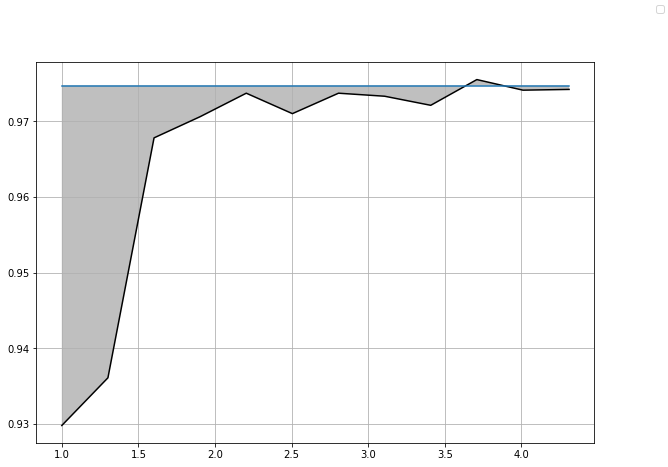

In [114]:
from shapely.geometry import Polygon

fig1, ax1 = plt.subplots(1, 1, sharex=True)
nums = np.array(num_labels_range)
colors = ['black', 'blue', 'red']
# for i in range(len(layers)):
#     means = acc_df[layers[i]].apply(mean)
#     stds = acc_df[layers[i]].apply(std)
#     ax1[i].plot(np.log10(nums), means, color=colors[i], label=layers[i]+' + L2 (lambda = 0.01)')
#     ax1[i].fill_between(np.log10(nums), means - stds, means + stds, facecolor=colors[i], interpolate=True, alpha=0.25)
#     ax1[i].grid()

for i in range(1):#len(layers)):
    means = acc_df[0].apply(mean)
    stds = acc_df[0].apply(std)
    ax1.plot(np.log10(nums), means, color=colors[i])
    ax1.plot(np.log10(nums), performance * np.ones(len(nums)))
    #ax1[i].fill_between(np.log10(nums), means - stds, means + stds, facecolor=colors[i], interpolate=True, alpha=0.25)
    ax1.fill_between(np.log10(nums), means, performance * np.ones(len(nums)), facecolor=colors[i], interpolate=True, alpha=0.25)
    ax1.grid()
# ax1[-1].set_xlabel('# Labels')
# ax1[1].set_ylabel('Accuracy')

fig1.legend()
fig1.set_size_inches(10, 7, forward=True)
fig1.savefig('acc_beta1.png')

In [109]:
acc_df[0].to_numpy()

array([0.9298, 0.9361, 0.9678, 0.9706, 0.9737, 0.971 , 0.9737, 0.9733,
       0.9721, 0.9755, 0.9741, 0.9742])

In [110]:
perf = performance * np.ones(len(nums))
def target_metric(best_performance, accuracy_over_labels, nums):
    perf = best_performance * np.ones(len(nums))
    x_y_curve1 = [(np.log10(nums)[i], accuracy_over_labels[i]) for i in range(len(nums))]#[(1,1),(2,1),(3,3),(4,3)] #these are your points for curve 1 
    x_y_curve2 = [(np.log10(nums)[i], perf[i]) for i in range(len(nums))] #these are your points for curve 2 

    polygon_points = [] #creates a empty list where we will append the points to create the polygon

    for xyvalue in x_y_curve1:
        polygon_points.append([xyvalue[0],xyvalue[1]]) #append all xy points for curve 1

    for xyvalue in x_y_curve2[::-1]:
        polygon_points.append([xyvalue[0],xyvalue[1]]) #append all xy points for curve 2 in the reverse order (from last point to first point)

    for xyvalue in x_y_curve1[0:1]:
        polygon_points.append([xyvalue[0],xyvalue[1]]) #append the first point in curve 1 again, to it "closes" the polygon

    polygon = Polygon(polygon_points)
    area = polygon.area
    return area

def accuracy_at_percent(percentage):
    num_labels = percentage * len(train_set)
    print(num_labels)

metric_value = target_metric(performance, acc_df[0].to_numpy(), nums)



0.024624167749608718


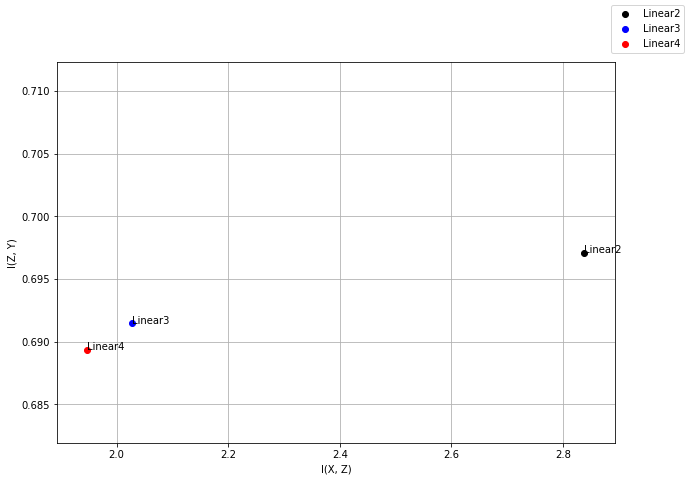

In [0]:
mi_df = pd.DataFrame.from_dict(mi_layers)
fig2, ax2 = plt.subplots(1, 1, sharex=True)
colors = ['black', 'blue', 'red']
for i in range(len(layers)):
    ax2.scatter(mi_df.loc[0, layers[i]], mi_df.loc[1, layers[i]], color=colors[i], label=layers[i])
    
    ax2.annotate(layers[i], (mi_df.loc[0, layers[i]], mi_df.loc[1, layers[i]]))
    ax2.grid()
ax2.set_xlabel('I(X, Z)')
ax2.set_ylabel('I(Z, Y)')

fig2.legend()
fig2.set_size_inches(10, 7, forward=True)
fig2.savefig('mi_l2.png')